In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from joblib import parallel_backend
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    precision_recall_curve,
    ConfusionMatrixDisplay
)

In [3]:
train_df = pd.read_csv("Tables/bnpl_train.csv")
test_df = pd.read_csv("Tables/bnpl_test.csv")
val_df = pd.read_csv("Tables/bnpl_val.csv")
target_col = "default_flag"
SEED = 42

In [4]:
print(train_df.shape, test_df.shape, val_df.shape)
print(train_df.head(), test_df.head(), val_df.head())
print("Train nulls in target:", train_df["default_flag"].isna().sum())
print("Train class distribution:\n", train_df["default_flag"].value_counts(normalize=True))

(595, 14) (199, 14) (199, 14)
   external_repayment_loans  credit_card_interest_incidence  default_flag  \
0                         1                               0             0   
1                         0                               0             0   
2                         0                               0             0   
3                         0                               1             0   
4                         1                               1             0   

   bnpl_usage_frequency  financial_stress_score  credit_limit_utilisation  \
0             -0.730258               -1.246089                 -1.746734   
1              1.319109                0.529472                 -0.222965   
2              0.408279                1.239697                  0.805578   
3             -1.641088                1.594809                 -0.184871   
4              0.408279                0.529472                 -1.556263   

   payment_delinquency_count  impulsive_buyi

In [5]:
X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col]
print("X_train shape:", X_train.shape, X_train.head())
print("y_train shape:", y_train.shape, y_train.head())



X_train shape: (595, 13)    external_repayment_loans  credit_card_interest_incidence  \
0                         1                               0   
1                         0                               0   
2                         0                               0   
3                         0                               1   
4                         1                               1   

   bnpl_usage_frequency  financial_stress_score  credit_limit_utilisation  \
0             -0.730258               -1.246089                 -1.746734   
1              1.319109                0.529472                 -0.222965   
2              0.408279                1.239697                  0.805578   
3             -1.641088                1.594809                 -0.184871   
4              0.408279                0.529472                 -1.556263   

   payment_delinquency_count  impulsive_buying_score  \
0                  -1.500097               -0.528311   
1                  -1

In [6]:
X_test = test_df.drop(columns=[target_col])
y_test = test_df[target_col]
print("X_test shape:", X_test.shape, X_test.head())
print("y_test shape:", y_test.shape, y_test.head())

X_test shape: (199, 13)    external_repayment_loans  credit_card_interest_incidence  \
0                         0                               0   
1                         0                               1   
2                         1                               0   
3                         0                               0   
4                         0                               0   

   bnpl_usage_frequency  financial_stress_score  credit_limit_utilisation  \
0              0.180572               -0.890977                  0.005600   
1             -1.413380                1.594809                  1.643651   
2              1.546817                0.174360                 -1.670546   
3             -1.413380               -0.180752                 -1.327698   
4             -0.047135                0.529472                  1.567463   

   payment_delinquency_count  impulsive_buying_score  \
0                   1.462180                0.504892   
1                  -0.

In [7]:
X_val = val_df.drop(columns=[target_col])
y_val = val_df[target_col]
print("X_val shape:", X_val.shape, X_val.head())
print("y_val shape:", y_val.shape, y_val.head())

X_val shape: (199, 13)    external_repayment_loans  credit_card_interest_incidence  \
0                         0                               1   
1                         0                               0   
2                         0                               0   
3                         1                               0   
4                         0                               1   

   bnpl_usage_frequency  financial_stress_score  credit_limit_utilisation  \
0             -0.502550                1.239697                  0.272259   
1              0.408279               -0.535864                 -1.670546   
2              0.635987               -0.890977                  0.043694   
3             -0.730258                0.884585                 -0.108683   
4              0.635987                0.529472                 -0.337248   

   payment_delinquency_count  impulsive_buying_score  \
0                  -0.907642                0.160491   
1                   1.4

In [8]:
print(y_train.value_counts(normalize=True))
print(y_val.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))


default_flag
0    0.922689
1    0.077311
Name: proportion, dtype: float64
default_flag
0    0.919598
1    0.080402
Name: proportion, dtype: float64
default_flag
0    0.919598
1    0.080402
Name: proportion, dtype: float64


Model

In [9]:
# Fit without early stopping:
XG_model = XGBClassifier(random_state=SEED,
                      use_label_encoder=False,
                      eval_metric="logloss")  

XG_model.fit(X_train, y_train)

# Predict & evaluate:
y_valid_proba = XG_model.predict_proba(X_val)[:, 1]
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_val, y_valid_proba)
print(f"Validation ROC AUC: {auc:.4f}")


Validation ROC AUC: 1.0000


C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.2032.0_x64__qbz5n2kfra8p0\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:51:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [10]:

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

rs = RandomizedSearchCV(
    estimator=XGBClassifier(
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=SEED,
        n_jobs=1,               # avoid nested process pools in XGBoost
    ),
    param_distributions=param_dist,
    n_iter=50,
    scoring="roc_auc",
    cv=3,
    verbose=1,
    n_jobs=-1,                 # we’ll turn this into threads below
    random_state=SEED
)

with parallel_backend("threading"):    # <- uses threads, no subprocess spawn
    rs.fit(X_train, y_train)


Fitting 3 folds for each of 50 candidates, totalling 150 fits


C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.2032.0_x64__qbz5n2kfra8p0\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:51:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [11]:
best_params = rs.best_params_

# Re-instantiate with best params
best_model = XGBClassifier(
    **best_params,
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=SEED
)

# Fit on train + valid (optional) or just train
best_model.fit(
    X_train,
    y_train,
    # if your version supports it:
    #early_stopping_rounds=10,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# Final AUC on the validation set:
y_valid_proba = best_model.predict_proba(X_val)[:, 1]
print("Tuned model ROC AUC on valid: ",
      roc_auc_score(y_val, y_valid_proba))


Tuned model ROC AUC on valid:  1.0


C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.2032.0_x64__qbz5n2kfra8p0\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:51:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [12]:
print("Best CV AUC (3-fold on train):", rs.best_score_)
print("Best hyperparameters:", rs.best_params_)


Best CV AUC (3-fold on train): 0.9990588949605343
Best hyperparameters: {'subsample': 1.0, 'reg_lambda': 2, 'reg_alpha': 0, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 1.0}


In [13]:
# 1. Predict class labels and probabilities
y_pred      = best_model.predict(X_test)
y_proba_pos = best_model.predict_proba(X_test)[:, 1]

# 2. Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)
# Optionally, label rows/cols if you want prettier output:
#   tn, fp, fn, tp = cm.ravel()

# 3. Precision, Recall, F1 (binary)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1-score:  {f1:.3f}")

# 4. AUC (just to confirm)
auc = roc_auc_score(y_test, y_proba_pos)
print(f"ROC AUC:   {auc:.3f}")

# 5. Full classification report
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))

Confusion matrix:
 [[183   0]
 [  3  13]]
Precision: 1.000
Recall:    0.812
F1-score:  0.897
ROC AUC:   1.000

Classification report:
              precision    recall  f1-score   support

           0      0.984     1.000     0.992       183
           1      1.000     0.812     0.897        16

    accuracy                          0.985       199
   macro avg      0.992     0.906     0.944       199
weighted avg      0.985     0.985     0.984       199



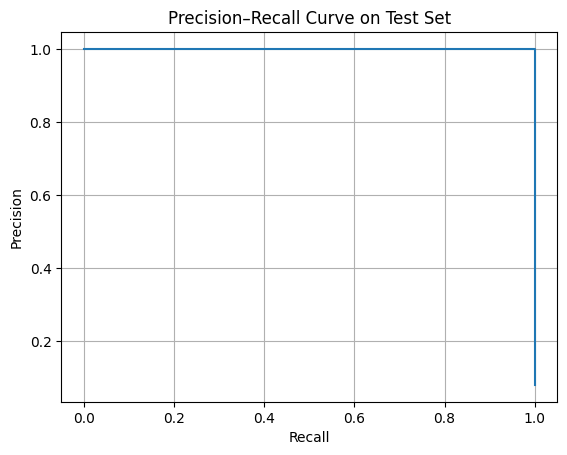

In [14]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba_pos)

plt.figure()
plt.plot(recalls, precisions)      # no specific colors
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve on Test Set")
plt.grid(True)
plt.show()


In [15]:

def eval_at_thresh(thresh):
    y_pred_thresh = (y_proba_pos >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresh).ravel()
    prec = precision_score(y_test, y_pred_thresh)
    rec  = recall_score(y_test, y_pred_thresh)
    f1   = f1_score(y_test, y_pred_thresh)
    print(f"Threshold = {thresh:.2f}")
    print(f"  Confusion matrix: [[{tn}, {fp}], [{fn}, {tp}]]")
    print(f"  Precision: {prec:.3f}   Recall: {rec:.3f}   F1: {f1:.3f}\n")

# Example thresholds
for t in [0.2, 0.3, 0.4, 0.5, 0.6]:
    eval_at_thresh(t)


Threshold = 0.20
  Confusion matrix: [[183, 0], [2, 14]]
  Precision: 1.000   Recall: 0.875   F1: 0.933

Threshold = 0.30
  Confusion matrix: [[183, 0], [2, 14]]
  Precision: 1.000   Recall: 0.875   F1: 0.933

Threshold = 0.40
  Confusion matrix: [[183, 0], [2, 14]]
  Precision: 1.000   Recall: 0.875   F1: 0.933

Threshold = 0.50
  Confusion matrix: [[183, 0], [3, 13]]
  Precision: 1.000   Recall: 0.812   F1: 0.897

Threshold = 0.60
  Confusion matrix: [[183, 0], [4, 12]]
  Precision: 1.000   Recall: 0.750   F1: 0.857



In [16]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba_pos)
f1s = 2 * (precisions * recalls) / (precisions + recalls)
best_idx = f1s.argmax()
print("Best F1:", f1s[best_idx], "at thresh =", thresholds[best_idx])


Best F1: 1.0 at thresh = 0.07568469


In [19]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)
results = {
    "threshold": float (thresholds[best_idx]),
    "confusion_matrix": confusion_matrix(y_test, y_pred).tolist(),
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precisions[best_idx],
    "recall": recalls[best_idx],
    "f1_score": f1s[best_idx],
    "roc_auc": roc_auc_score(y_test, y_proba_pos),
    "fpr": fpr.tolist(),
    "tpr": tpr.tolist(),
    "roc_thresholds": threshold.tolist(),
    
}
with open("Results/XGB_model_results.json", "w") as f:
    json.dump(results, f)

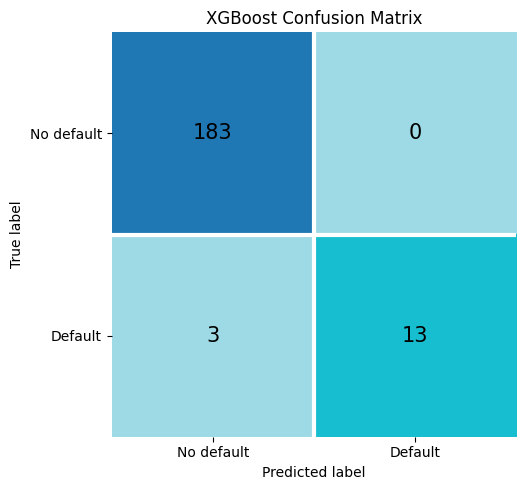

In [18]:

# Raw counts
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No default', 'Default'])

# Plot with custom settings
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(values_format='d', cmap='tab20_r', ax=ax, colorbar=0)

# Make the numbers bigger
for text in disp.text_.ravel():   # text_ stores the annotation objects
    text.set_fontsize(15)
    text.set_color('black')  # Set text color to black for better visibility
n_classes = cm.shape[0]
for i in range(1, n_classes):  
    ax.axhline(i - 0.5, color='white', linewidth=3)  # horizontal line
    ax.axvline(i - 0.5, color='white', linewidth=3)  # vertical line
for spine in ax.spines.values():
    spine.set_visible(False)
plt.title('XGBoost Confusion Matrix')
plt.savefig("Plots/Confusion Matricies/XGBoost_cm.png")
plt.tight_layout()
plt.show()